In [144]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Utils
from scipy.optimize import minimize 
import Backtest as bt   
import matplotlib.dates as mdates

In [145]:
# SET GLOBAL VALUES
mu_target = 75 / 10000 # Target
w_current = np.array([0,0.4, 0.6]) # current strategy

In [146]:
bond = pd.read_csv("Data_clean/bond_returns.csv")
stock = pd.read_csv("Data_clean/6_Portfolios_ME_Prior_12_2_returns.csv")
bond, stock =bond[["Date", "10YrReturns"]], stock[["Date", "Market Return"]]
stock["Market Return"] = stock["Market Return"] /100

In [147]:
data = pd.merge(bond,stock, how='left', on = "Date")
RF = pd.read_csv("Data_clean/FF_cleaned.csv")
data = pd.merge(data.copy(),RF, 'left',on = "Date" )
data["RF"] = data["RF"] /100 # assumed this must hold

data = data.drop(columns = ["Mkt-RF", "SMB", "HML"])

Figure 1

C:\Users\andre\AppData\Local\Temp\ipykernel_29816\2515805578.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


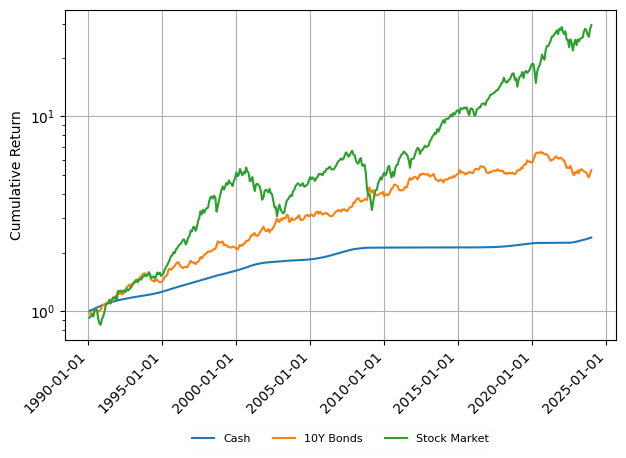

In [148]:
# Plot timeseries of returns to get a feeling of how it looks:
time = pd.date_range(data["Date"][0],data["Date"][len(data["Date"]) -1 ], freq = 'ME')
acc_return = (1 + data[["RF","10YrReturns","Market Return"]]).cumprod() 
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,acc_return["RF"], label="Cash")
ax.plot(time,acc_return["10YrReturns"], label="10Y Bonds")
ax.plot(time,acc_return["Market Return"], label="Stock Market")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative Return")
#plt.title("Cumulative returns of each asset")
plt.savefig("Figures/Returns_assets",bbox_inches='tight')
plt.show()


Table 1

In [149]:
mu = np.mean([data["RF"],data["10YrReturns"],data["Market Return"]],axis=1)
sigma = np.cov([data["RF"],data["10YrReturns"],data["Market Return"]])
mu2 = np.mean([data["10YrReturns"],data["Market Return"]],axis=1)
sigma2 = np.cov([data["10YrReturns"],data["Market Return"]])
print("Mu", mu,"Sigma", sigma)

Mu [0.00213848 0.00432316 0.00930956] Sigma [[ 3.53053036e-06  4.63693106e-06 -2.61646372e-07]
 [ 4.63693106e-06  4.51987323e-04 -6.42279174e-05]
 [-2.61646372e-07 -6.42279174e-05  1.94512573e-03]]


In [150]:
# Current portfolio return and risk:
mu_4060 = w_current @ mu 
sigma_4060 =np.sqrt(w_current @ sigma @ w_current)

print("PF-value per month in bps", mu_4060 , "PF-std" , sigma_4060 )

PF-value per month in bps 0.007315000330233509 PF-std 0.02723479088829775


In [151]:
# Check of MV optimal:
print("Optimal porfolio given 40/60 return and no shorting:",Utils.min_var(mu, sigma,mu_4060)[0].round(3) )
# Except from numerical instability, true. 
w_6040target =Utils.min_var(mu, sigma,mu_4060)
sigma_6040target = Utils.min_var(mu, sigma,mu_4060)[1]

Optimal porfolio given 40/60 return and no shorting: [-0.   0.4  0.6]


In [152]:
# minimum variance given target (no shorting!):
w_target, sigma_target = Utils.min_var(mu, sigma,mu_target) 
print("Weight:", w_target.round(4), "Minimum std of target mu",sigma_target, "Mu" )

Weight: [-0.      0.3629  0.6371] Minimum std of target mu 0.02862424015349705 Mu


In [153]:
# But if we consider the actual return from the pf:
# w_target, sigma_target = Utils.min_var(mu, sigma,mu_4060) 
# print("Weight:", w_target, "Minimum sigma of target mu",sigma_target)
# Actually really close to mean variance efficient
#BUT: IT DOES NOT DELIVER THE CORRESPONDING RETURN!
print("Return current PF", mu_4060, "!= Return Target",mu_target)
print("Reduction in risk in Variance:", (sigma_6040target -  sigma_4060)*10000 )
# Reduction of 12 Bps!!

Return current PF 0.007315000330233509 != Return Target 0.0075
Reduction in risk in Variance: -3.469446951953614e-14


In [154]:
# Plot mean variance frontier:
mu_vec = np.array([mu_target + i*0.0001 for i in range(-80,40)])
sigma_vec = [Utils.mv_analysis(mu, sigma,i)[1] for i in mu_vec]

Figure 2

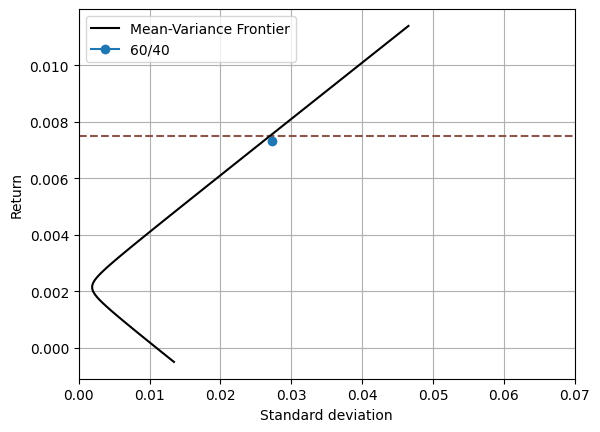

In [155]:
plt.axhline(y=0.0075, color='C5', linestyle='--')
plt.plot(sigma_vec, mu_vec, color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_4060,mu_4060,marker='o', label = "60/40")
#plt.plot(sigma_target,mu_target,marker='o', label = "MV")
#plt.plot(sigma_target_e,mu_cml,marker='o', label = "LMV")
#plt.plot(sigma_rp,mu_rp,marker='o', label = "RP")
#plt.plot(sigma_rp_lev,mu_rp_lev,marker='o', label = "LRP")
plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.xlim(left = 0.0,right= 0.07)

plt.grid()
plt.show()

In [156]:
# We can then use functionality...
mu0 = np.mean(data["RF"])
mu_e = np.mean([data["10YrReturns"] - data["RF"],data["Market Return"]-data["RF"]],axis=1)
sigma_e = np.cov([data["10YrReturns"] - data["RF"],data["Market Return"] - data["RF"]])
mu_target_e = mu_target - mu0
mu_e, sigma_e

(array([0.00218468, 0.00717108]),
 array([[ 4.46243992e-04, -6.50726717e-05],
        [-6.50726717e-05,  1.94917955e-03]]))

In [157]:
w_target, sigma_target_e = Utils.min_var_rf(mu, sigma,mu_target) 
print(w_target, sigma_target_e)
# Got riskier.

[-0.25901786  0.73540008  0.52361778] 0.026959668877929645


In [158]:
# Surprisingly risk is increased?
# Return:
mu_cml = np.array(w_target) @ np.array(mu) 
print(mu_cml)

0.007499999999999999


Risk Parity

In [159]:
# Alternative RP - sanity:
w_rp = Utils.rp_gb(sigma) # note this apporach yields same result!
sigma_rp = np.sqrt(w_rp @ sigma @ w_rp)
mu_rp = w_rp @ mu
check = w_rp *  ( sigma @ w_rp) /sigma_rp
pf_risk = check + check
print("Actual risk weight", check,"Portfolio risk", pf_risk)
w_rpl = Utils.rp_gb_lev(w_rp,mu,mu_target)
sigma_rpp = np.sqrt(w_rpl[1:] @ sigma2 @ w_rpl[1:])
check = w_rpl[1:] *  ( sigma2 @ w_rpl[1:]) /sigma_rpp
pf_risk = check + check
print("Actual risk weight", check, "Portfolio risk", pf_risk)
print("Returns:", w_rpl @ mu)
sigma_rpl = np.sqrt(w_rpl[1:] @ sigma2 @ w_rpl[1:])
mu_rpl = w_rpl @ mu

Actual risk weight [0.         0.00978989 0.00978989] Portfolio risk [0.         0.01957978 0.01957978]
Actual risk weight [0.01378906 0.01378906] Portfolio risk [0.02757812 0.02757812]
Returns: 0.0075


Figure 3

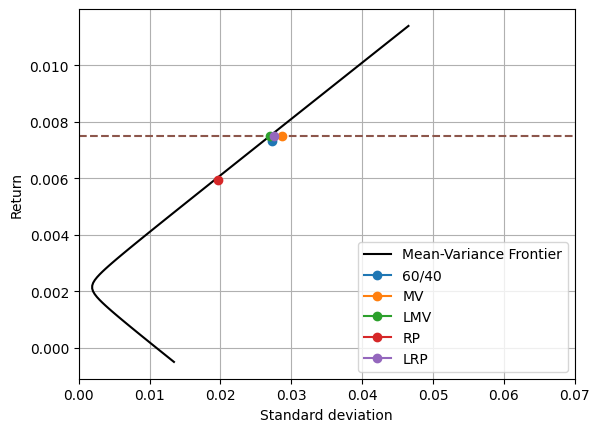

In [160]:
plt.axhline(y=0.0075, color='C5', linestyle='--')
plt.plot(sigma_vec, mu_vec, color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_4060,mu_4060,marker='o', label = "60/40")
plt.plot(sigma_target,mu_target,marker='o', label = "MV")
plt.plot(sigma_target_e,mu_cml,marker='o', label = "LMV")
plt.plot(sigma_rp,mu_rp,marker='o', label = "RP")
plt.plot(sigma_rpl,mu_rpl,marker='o', label = "LRP")
plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.xlim(left = 0.0,right= 0.07)

plt.grid()
plt.show()

Table 4

In [161]:
test2 =  Utils.get_weights2(mu,sigma, mu_target)
print([test2[i].round(2) for i in range(len(test2))])

[array([0. , 0.4, 0.6]), array([-0.  ,  0.36,  0.64]), array([-0.26,  0.74,  0.52]), array([0.  , 0.67, 0.33]), array([-0.41,  0.95,  0.46])]


In [162]:
sigma_test, mu_test = [np.sqrt(w @ sigma @ w) for w in test2],  [w @ mu for w in test2]

print([mu_test[i].round(4) for i in range(len(test2))])
print([sigma_test[i].round(4) for i in range(len(test2))])

[np.float64(0.0073), np.float64(0.0075), np.float64(0.0075), np.float64(0.0059), np.float64(0.0075)]
[np.float64(0.0272), np.float64(0.0286), np.float64(0.027), np.float64(0.0196), np.float64(0.0275)]


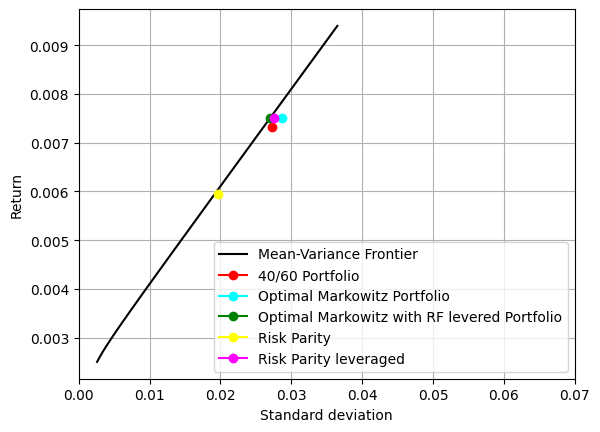

In [163]:
plt.plot(sigma_vec[30:100], mu_vec[30:100], color = "black",label = "Mean-Variance Frontier")
plt.plot(sigma_test[0],mu_test[0],marker='o', color = "red", label = "40/60 Portfolio")
plt.plot(sigma_test[1],mu_test[1],marker='o', color = "cyan", label = "Optimal Markowitz Portfolio")
plt.plot(sigma_test[2],mu_test[2],marker='o', color = "green", label = "Optimal Markowitz with RF levered Portfolio")
plt.plot(sigma_test[3],mu_test[3],marker='o', color = "yellow", label = "Risk Parity")
plt.plot(sigma_test[4],mu_test[4],marker='o', color = "magenta", label = "Risk Parity leveraged")
plt.xlim(left = 0.0,right= 0.07)

plt.legend()
plt.xlabel("Standard deviation")
plt.ylabel("Return")
plt.grid()
plt.show()

### Backtests

#### Figure4

Naive:

In [164]:
data_naive, w_naive, monthly_naive, metrics_naive,olay = bt.backtest_naive2(data, mu_target)

In [165]:
metrics_naive

,Mean Monthly Returns,Annualized Excess Returns,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis
R_40/60,0.007315,0.062118,0.094353,0.658362,-0.458751,1.087525
R_MV,0.007500,0.064338,0.099187,0.648653,-0.470164,1.063344
R_MVL,0.007500,0.064338,0.093315,0.689475,-0.393308,1.271315
R_RP,0.005945,0.045679,0.067600,0.675720,-0.350874,1.306783
R_RPL,0.007500,0.064338,0.095214,0.675720,-0.350874,1.306783


C:\Users\andre\AppData\Local\Temp\ipykernel_29816\773285581.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


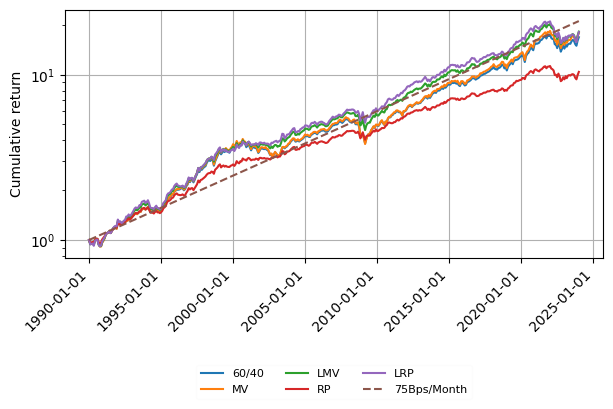

In [166]:
df_const = pd.DataFrame([[1,1,1,1,1,1,'1989-12-31']],columns=
                        data_naive.columns)
data_naive = pd.concat([df_const,data_naive], ignore_index=True)

time = pd.date_range(data_naive["Date"][0],data_naive["Date"][len(data_naive["Date"]) -1 ], freq = 'ME')

fig, ax = plt.subplots(layout='constrained')
ax.plot(time,data_naive["R_40/60"], label="60/40")
ax.plot(time,data_naive["R_MV"], label="MV")
ax.plot(time,data_naive["R_MVL"], label="LMV")
ax.plot(time,data_naive["R_RP"], label="RP")
ax.plot(time,data_naive["R_RPL"], label="LRP")
ax.plot(time, [(mu_target+1)**(t) for t in range(0,len(time))],
         label = "75Bps/Month", linestyle = 'dashed')

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
# plt.title("Entire Period: 1990-2023")
plt.savefig("Figures/BT_naive_full",bbox_inches='tight')
plt.show()

In [167]:
# TODO: DECIDE HOW OFTEN TO REBALANCE 
initial_fits = 12
l_fits = 1
K_fits = 1

test1, weights1, test2, metrics,olay = bt.backtest_k(ind=data, mu_target=mu_target,m=initial_fits,l=l_fits,K=K_fits) 

In [168]:
metrics



,Mean Monthly Returns,Annualized Excess Returns,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis
R_40/60,0.007529,0.066198,0.092709,0.714042,-0.457561,1.175702
R_MV,0.006948,0.059234,0.092195,0.642483,-0.223949,3.586668
R_MVL,0.006161,0.049791,0.074369,0.669520,-0.300893,2.539952
R_RP,0.006069,0.048680,0.066394,0.733196,-0.357289,1.331772
R_RPL,0.006723,0.056528,0.078626,0.718948,-0.368532,2.185436


In [169]:
metrics_naive



,Mean Monthly Returns,Annualized Excess Returns,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis
R_40/60,0.007315,0.062118,0.094353,0.658362,-0.458751,1.087525
R_MV,0.007500,0.064338,0.099187,0.648653,-0.470164,1.063344
R_MVL,0.007500,0.064338,0.093315,0.689475,-0.393308,1.271315
R_RP,0.005945,0.045679,0.067600,0.675720,-0.350874,1.306783
R_RPL,0.007500,0.064338,0.095214,0.675720,-0.350874,1.306783


Table 5

In [170]:
latex_table = metrics.to_latex(index=True, float_format="%.4f", caption="Backtest performance", label="tab:bt")
print(latex_table)

latex_table = metrics_naive.to_latex(index=True, float_format="%.4f", caption="Backtest performance", label="tab:bt")
print(latex_table)

\begin{table}
\caption{Backtest performance}
\label{tab:bt}
\begin{tabular}{lrrrrrr}
\toprule
 & Mean Monthly Returns & Annualized Excess Returns & Volatility & Sharpe Ratio & Skewness & Excess Kurtosis \\
\midrule
R_40/60 & 0.0075 & 0.0662 & 0.0927 & 0.7140 & -0.4576 & 1.1757 \\
R_MV & 0.0069 & 0.0592 & 0.0922 & 0.6425 & -0.2239 & 3.5867 \\
R_MVL & 0.0062 & 0.0498 & 0.0744 & 0.6695 & -0.3009 & 2.5400 \\
R_RP & 0.0061 & 0.0487 & 0.0664 & 0.7332 & -0.3573 & 1.3318 \\
R_RPL & 0.0067 & 0.0565 & 0.0786 & 0.7189 & -0.3685 & 2.1854 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Backtest performance}
\label{tab:bt}
\begin{tabular}{lrrrrrr}
\toprule
 & Mean Monthly Returns & Annualized Excess Returns & Volatility & Sharpe Ratio & Skewness & Excess Kurtosis \\
\midrule
R_40/60 & 0.0073 & 0.0621 & 0.0944 & 0.6584 & -0.4588 & 1.0875 \\
R_MV & 0.0075 & 0.0643 & 0.0992 & 0.6487 & -0.4702 & 1.0633 \\
R_MVL & 0.0075 & 0.0643 & 0.0933 & 0.6895 & -0.3933 & 1.2713 \\
R_RP & 0.0059 & 0.

C:\Users\andre\AppData\Local\Temp\ipykernel_29816\2216840041.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


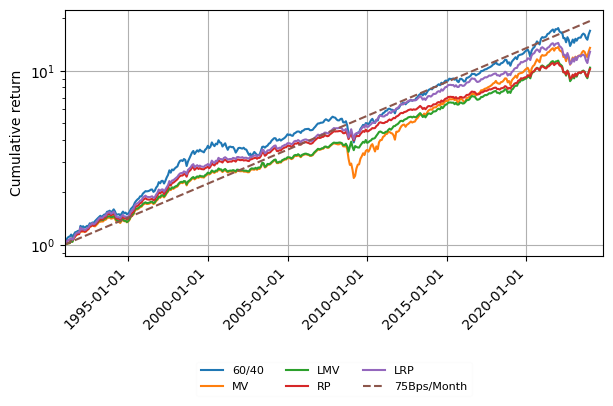

In [171]:
time = pd.date_range(test1["Date"][0],test1["Date"][len(test1["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test1["R_40/60"], label="60/40")
ax.plot(time,test1["R_MV"], label="MV")
ax.plot(time,test1["R_MVL"], label="LMV")
ax.plot(time,test1["R_RP"], label="RP")
ax.plot(time,test1["R_RPL"], label="LRP")
ax.plot(time[initial_fits-1:], [(mu_target+1)**(t+1) for t in range(-1,len(time)-initial_fits)],
         label = "75Bps/Month", linestyle = 'dashed')

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.xlim((pd.Timestamp('1990-12-31'),pd.Timestamp.now()))

#plt.title("Entire Period: 1990-2023")
plt.savefig("Figures/BT_actual_full",bbox_inches='tight')

plt.show()

Figure 6 right

C:\Users\andre\AppData\Local\Temp\ipykernel_29816\3165882320.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


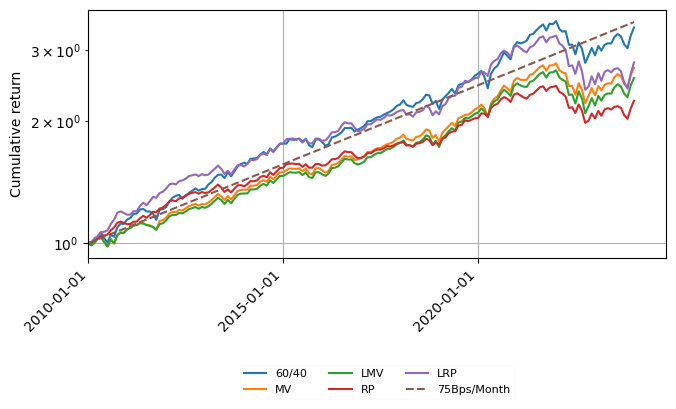

In [172]:
data1 = data.copy()
# Now perform the comparison
data1 = data1[pd.Timestamp('2009-01-31') <=pd.to_datetime(data1["Date"])]
data1 = data1.reset_index().drop(columns = "index")

test2, weights2, empt1, empt2, empt3= bt.backtest_k(ind=data1, mu_target=mu_target,m=initial_fits,l=l_fits,K=K_fits) # 36 trailing month windowfig,
time = pd.date_range(test2["Date"][0],test2["Date"][len(test2["Date"]) -1 ], freq = 'ME')

firg, ax = plt.subplots(layout='constrained')
ax.plot(time,test2["R_40/60"], label="60/40")
ax.plot(time,test2["R_MV"], label="MV")
ax.plot(time,test2["R_MVL"], label="LMV")
ax.plot(time,test2["R_RP"], label="RP")
ax.plot(time,test2["R_RPL"], label="LRP")
ax.plot(time[initial_fits-1:], [(mu_target+1)**(t+1) for t in range(-1,len(time)-initial_fits)],
         label = "75Bps/Month", linestyle = 'dashed')

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.xlim((pd.Timestamp('2009-12-31'),pd.Timestamp.now()))

# plt.title("Subperiod: 2010-2023")
plt.savefig("Figures/BT_actual_2010_2023",bbox_inches='tight')

plt.show()


Figure 5 right

C:\Users\andre\AppData\Local\Temp\ipykernel_29816\2394129025.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


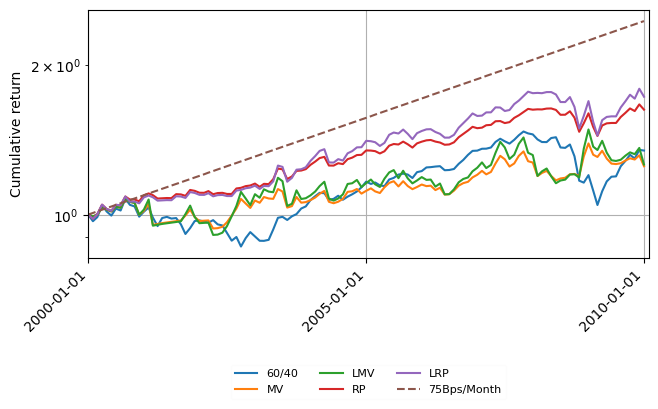

In [173]:
data1 = data.copy()
# Now perform the comparison
data1 = data1[(pd.Timestamp('2010-01-31') > pd.to_datetime(data1["Date"])) & (pd.Timestamp('1999-01-31') <= pd.to_datetime(data1["Date"]))]
data1 = data1.reset_index().drop(columns = "index")

test3, weights3 ,empt1, empt, empt3= bt.backtest_k(ind=data1, mu_target=mu_target,m=initial_fits,l=l_fits,K=K_fits) # 36 trailing month window
time = pd.date_range(test3["Date"][0],test3["Date"][len(test3["Date"]) -1 ], freq = 'ME')

fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test3["R_40/60"], label="60/40")
ax.plot(time,test3["R_MV"], label="MV")
ax.plot(time,test3["R_MVL"], label="LMV")
ax.plot(time,test3["R_RP"], label="RP")
ax.plot(time,test3["R_RPL"], label="LRP")
ax.plot(time[initial_fits-1:], [(mu_target+1)**(t+1) for t in range(-1,len(time)-initial_fits)],
         label = "75Bps/Month", linestyle = 'dashed')

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.xlim((pd.Timestamp('1999-12-31'),pd.Timestamp('2010-01-31')))
plt.yscale('log')
plt.ylabel("Cumulative return")
#plt.title("Entire Period: 2000-2010")
plt.savefig("Figures/BT_actual_2000_2010",bbox_inches='tight')

plt.show()


Figure 6 left

C:\Users\andre\AppData\Local\Temp\ipykernel_29816\3404650402.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


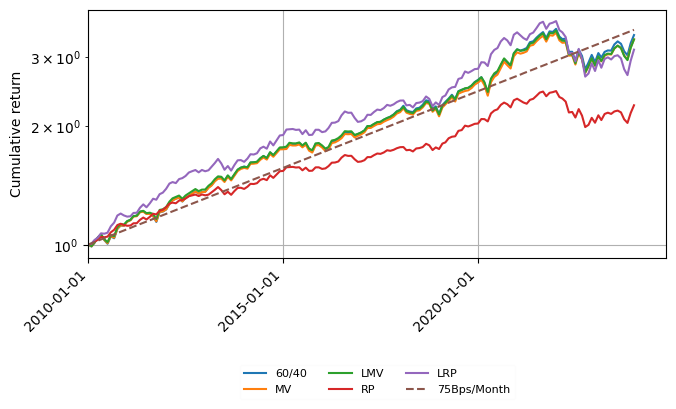

In [174]:
data1 = data.copy()
# Now perform the comparison
data1 = data1[pd.Timestamp('2010-01-31') <=pd.to_datetime(data1["Date"])]
data1 = data1.reset_index().drop(columns = "index")

test2, weights2_naive, empt1, metrics_naive2, empt3 = bt.backtest_naive2(ind=data1, mu_target=mu_target) # 36 trailing month windowfig,
df_const = pd.DataFrame([[1,1,1,1,1,1,'2009-12-31']],columns=
                        test2.columns)
test2 = pd.concat([df_const,test2], ignore_index=True)

time = pd.date_range(test2["Date"][0],test2["Date"][len(test2["Date"]) -1 ], freq = 'ME')

firg, ax = plt.subplots(layout='constrained')
ax.plot(time,test2["R_40/60"], label="60/40")
ax.plot(time,test2["R_MV"], label="MV")
ax.plot(time,test2["R_MVL"], label="LMV")
ax.plot(time,test2["R_RP"], label="RP")
ax.plot(time,test2["R_RPL"], label="LRP")
ax.plot(time[0:], [(mu_target+1)**(t) for t in range(0,len(time))],
         label = "75Bps/Month", linestyle = 'dashed')

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.xlim((pd.Timestamp('2009-12-31'),pd.Timestamp.now()))

# plt.title("Subperiod: 2010-2023")
plt.savefig("Figures/BT_naive_2010_2023",bbox_inches='tight')

plt.show()

Figure 5 left

C:\Users\andre\AppData\Local\Temp\ipykernel_29816\3491934653.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


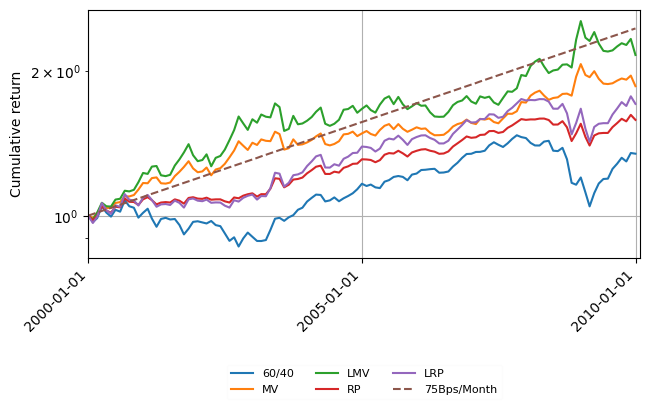

In [175]:
data1 = data.copy()
# Now perform the comparison
data1 = data1[(pd.Timestamp('2010-01-31') > pd.to_datetime(data1["Date"])) & (pd.Timestamp('2000-01-31') <= pd.to_datetime(data1["Date"]))]
data1 = data1.reset_index().drop(columns = "index")

test3, weights3_naive ,empt1, metrics_naive3, empt3= bt.backtest_naive2(ind=data1, mu_target=mu_target) # 36 trailing month window
df_const = pd.DataFrame([[1,1,1,1,1,1,'1999-12-31']],columns=
                        test3.columns)
test3 = pd.concat([df_const,test3], ignore_index=True)
time = pd.date_range(test3["Date"][0],test3["Date"][len(test3["Date"]) -1 ], freq = 'ME')

fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test3["R_40/60"], label="60/40")
ax.plot(time,test3["R_MV"], label="MV")
ax.plot(time,test3["R_MVL"], label="LMV")
ax.plot(time,test3["R_RP"], label="RP")
ax.plot(time,test3["R_RPL"], label="LRP")
ax.plot(time[0:], [(mu_target+1)**(t) for t in range(0,len(time))],
         label = "75Bps/Month", linestyle = 'dashed')

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.xlim((pd.Timestamp('1999-12-31'),pd.Timestamp('2010-01-31')))

plt.ylabel("Cumulative return")
#plt.title("Entire Period: 2000-2010")
plt.savefig("Figures/BT_naive_2000_2010",bbox_inches='tight')

plt.show()

Table 6 construction

In [176]:
print("Weights full", w_naive.round(2))
print("Weights 2010-2023", weights2_naive.round(2))
print("Weights 2000-2010", weights3_naive.round(2))


Weights full [[ 0.    0.4   0.6 ]
 [-0.    0.36  0.64]
 [-0.26  0.74  0.52]
 [ 0.    0.67  0.33]
 [-0.41  0.95  0.46]
 [ 1.    0.    0.  ]]
Weights 2010-2023 [[ 0.    0.4   0.6 ]
 [ 0.    0.42  0.58]
 [-0.05  0.48  0.57]
 [ 0.    0.68  0.32]
 [-0.5   1.02  0.48]
 [ 1.    0.    0.  ]]
Weights 2000-2010 [[ 0.    0.4   0.6 ]
 [-0.    1.   -0.  ]
 [-0.5   1.5   0.  ]
 [ 0.    0.67  0.33]
 [-0.5   1.    0.5 ]
 [ 1.    0.    0.  ]]


In [177]:
# Get mean returns and std.
data1 = data.copy()
data1 = data1[pd.Timestamp('2010-01-31') <=pd.to_datetime(data1["Date"])]
data1 = data1.reset_index().drop(columns = "index")
mu, sigma = bt.get_stats(data1, mu_target)
mus_naive2 = [(weights2_naive[i] @ mu).round(4) for i in range(len(weights2_naive))]
sigmas_naive2 = [np.sqrt(weights2_naive[i] @ sigma @ weights2_naive[i]).round(4) for i in range(len(weights2_naive))]
data1 = data.copy()
data1 = data1[(pd.Timestamp('2010-01-31') > pd.to_datetime(data1["Date"])) & (pd.Timestamp('2000-01-31') <= pd.to_datetime(data1["Date"]))]
data1 = data1.reset_index().drop(columns = "index")
mu, sigma = bt.get_stats(data1, mu_target)
mus_naive3 = [(weights3_naive[i] @ mu).round(4) for i in range(len(weights3_naive))]
sigmas_naive3 = [np.sqrt(weights3_naive[i] @ sigma @ weights3_naive[i]).round(4) for i in range(len(weights3_naive))]

print("Returns 2010-2023:", mus_naive2)
print("Std 2010-2023:", sigmas_naive2)
print("Returns 2000-2010:",mus_naive3)
print("std 2000-2010:", sigmas_naive3)



Returns 2010-2023: [np.float64(0.0077), np.float64(0.0075), np.float64(0.0075), np.float64(0.005), np.float64(0.0072), np.float64(0.0007)]
Std 2010-2023: [np.float64(0.0267), np.float64(0.026), np.float64(0.026), np.float64(0.0185), np.float64(0.0278), np.float64(0.0012)]
Returns 2000-2010: [np.float64(0.0029), np.float64(0.0055), np.float64(0.0071), np.float64(0.004), np.float64(0.0049), np.float64(0.0023)]
std 2000-2010: [np.float64(0.0277), np.float64(0.0237), np.float64(0.0355), np.float64(0.0194), np.float64(0.029), np.float64(0.0016)]


In [178]:
print("Metrics naive")
metrics_naive



Metrics naive


,Mean Monthly Returns,Annualized Excess Returns,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis
R_40/60,0.007315,0.062118,0.094353,0.658362,-0.458751,1.087525
R_MV,0.007500,0.064338,0.099187,0.648653,-0.470164,1.063344
R_MVL,0.007500,0.064338,0.093315,0.689475,-0.393308,1.271315
R_RP,0.005945,0.045679,0.067600,0.675720,-0.350874,1.306783
R_RPL,0.007500,0.064338,0.095214,0.675720,-0.350874,1.306783


In [179]:
print("Weights 2010-2023")
metrics_naive2

Weights 2010-2023


,Mean Monthly Returns,Annualized Excess Returns,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis
R_40/60,0.007671,0.083579,0.092660,0.902002,-0.311157,0.956337
R_MV,0.007500,0.081521,0.090241,0.903375,-0.318478,1.006815
R_MVL,0.007500,0.081521,0.090119,0.904599,-0.337644,1.123852
R_RP,0.005028,0.051862,0.064156,0.808386,-0.556873,1.819252
R_RPL,0.007189,0.077794,0.096233,0.808386,-0.556873,1.819252


In [180]:
print("Weights 2000-2010")
metrics_naive3

Weights 2000-2010


,Mean Monthly Returns,Annualized Excess Returns,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis
R_40/60,0.002859,0.007108,0.096115,0.073952,-0.631035,1.325400
R_MV,0.005459,0.038306,0.081792,0.468331,0.082553,1.744703
R_MVL,0.007055,0.057457,0.122685,0.468332,0.082550,1.744701
R_RP,0.004015,0.020985,0.067110,0.312692,-0.350879,1.476882
R_RPL,0.004890,0.031477,0.100665,0.312692,-0.350879,1.476882
